# Stable Diffusion Text-to-Image Demo

Stable Diffusion is an innovative generative AI technique that allows us to generate and manipulate images in interesting ways, including generating image from text and restoring missing parts of pictures (inpainting)!

Stable Diffusion <b>v2</b> provides great functionality over previous versions, including being able to use more data, employ more training, and has less restrictive filtering of the dataset. All of these features give us promising results for selecting a wide range of input text prompts!

**Note:** This is a shorter version of the [stable-diffusion-v2-text-to-image](../stable-diffusion-v2/stable-diffusion-v2-text-to-image.ipynb) notebook for demo purposes and to get started quickly. This version does not have the full implementation of the helper utilities needed to convert the models from PyTorch to ONNX to OpenVINO, and the OpenVINO `OVStableDiffusionPipeline` within the notebook directly. If you would like to see the full implementation of stable diffusion for text to image, please visit [stable-diffusion-v2-text-to-image](../stable-diffusion-v2/stable-diffusion-v2-text-to-image.ipynb).

#### Table of contents:

- [Step 0: Install and import prerequisites](#Step-0:-Install-and-import-prerequisites)
- [Step 1: Stable Diffusion v2 Fundamental components](#Step-1:-Stable-Diffusion-v2-Fundamental-components)
    - [Step 1.1: Retrieve components from HuggingFace](#Step-1.1:-Retrieve-components-from-HuggingFace)
- [Step 2: Convert the models to OpenVINO](#Step-2:-Convert-the-models-to-OpenVINO)
- [Step 3: Text-to-Image Generation Inference Pipeline](#Step-3:-Text-to-Image-Generation-Inference-Pipeline)
    - [Step 3.1: Load and Understand Text to Image OpenVINO models](#Step-3.1:-Load-and-Understand-Text-to-Image-OpenVINO-models)
    - [Step 3.2: Select inference device](#Step-3.2:-Select-inference-device)
    - [Step 3.3: Run Text-to-Image generation](#Step-3.3:-Run-Text-to-Image-generation)



## Step 0: Install and import prerequisites
[back to top ⬆️](#Table-of-contents:)


To work with Stable Diffusion v2, we will use Hugging Face's [Diffusers](https://github.com/huggingface/diffusers) library. 

To experiment with Stable Diffusion models, Diffusers exposes the [`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) and `StableDiffusionInpaintPipeline`, similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview).  

In [2]:
%pip install -q "diffusers>=0.14.0" "openvino>=2023.1.0" "transformers>=4.31" accelerate "torch>=2.1" Pillow opencv-python --extra-index-url https://download.pytorch.org/whl/cpu


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 1: Stable Diffusion v2 Fundamental components
[back to top ⬆️](#Table-of-contents:)

Stable Diffusion pipelines for both <i>Text to Image</i> and <i>Inpainting</i> consist of three important parts:

1. A Text Encoder to create conditions: for example, generating an image from a text prompt or performing inpainting to create an infinite zoom effect.
2. A U-Net for step-by-step denoising of latent image representation.
3. An Autoencoder (VAE) for decoding the latent space to an image.

Depending on the pipeline, the parameters for these parts can differ, which we'll explore in this demo! 

### Step 1.1: Retrieve components from HuggingFace
[back to top ⬆️](#Table-of-contents:)

Let's start by retrieving these components from HuggingFace!

The code below demonstrates how to create `StableDiffusionPipeline` using `stable-diffusion-2-1`.

In [3]:
# Retrieve the Text to Image Stable Diffusion pipeline components
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to("cpu")

# for reducing memory consumption get all components from pipeline independently
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

conf = pipe.scheduler.config

del pipe

2023-09-12 11:59:21.971103: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 11:59:22.005818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 11:59:22.607625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Step 2: Convert the models to OpenVINO
[back to top ⬆️](#Table-of-contents:)


Now that we've retrieved the three parts for both of these pipelines, we now need to:

1. Convert the original PyTorch models to OpenVINO format using Model Conversion API

```
ov_model_part = ov.convert_model(model_part, example_input=input_data)
```

2. Save OpenVINO models on disk:

```
ov.save_model(ov_model_part, xml_file_path)
```

We can then run our Stable Diffusion v2 text to image and inpainting pipelines in OpenVINO on our own data!

In [4]:
from pathlib import Path

# Define a dir to save text-to-image models
txt2img_model_dir = Path("sd2.1")
txt2img_model_dir.mkdir(exist_ok=True)

In [5]:
from implementation.conversion_helper_utils import (
    convert_encoder,
    convert_unet,
    convert_vae_decoder,
    convert_vae_encoder,
)

# Convert the Text-to-Image models from PyTorch -> Onnx -> OpenVINO
# 1. Convert the Text Encoder
txt_encoder_ov_path = txt2img_model_dir / "text_encoder.xml"
convert_encoder(text_encoder, txt_encoder_ov_path)
# 2. Convert the U-NET
unet_ov_path = txt2img_model_dir / "unet.xml"
convert_unet(unet, unet_ov_path, num_channels=4, width=96, height=96)
# 3. Convert the VAE encoder
vae_encoder_ov_path = txt2img_model_dir / "vae_encoder.xml"
convert_vae_encoder(vae, vae_encoder_ov_path, width=768, height=768)
# 4. Convert the VAE decoder
vae_decoder_ov_path = txt2img_model_dir / "vae_decoder.xml"
convert_vae_decoder(vae, vae_decoder_ov_path, width=96, height=96)

## Step 3: Text-to-Image Generation Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

### Step 3.1: Load and Understand Text to Image OpenVINO models
[back to top ⬆️](#Table-of-contents:)


### Step 3.2: Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [6]:
import ipywidgets as widgets
import openvino as ov

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

Let's create instances of our OpenVINO Model for Text to Image.

In [7]:
text_enc = core.compile_model(txt_encoder_ov_path, device.value)

In [8]:
unet_model = core.compile_model(unet_ov_path, device.value)

In [9]:
vae_encoder = core.compile_model(vae_encoder_ov_path, device.value)
vae_decoder = core.compile_model(vae_decoder_ov_path, device.value)

Next, we will define a few key elements to create the inference pipeline, as depicted in the diagram below:

![text2img-stable-diffusion](https://github.com/openvinotoolkit/openvino_notebooks/assets/22090501/ec454103-0d28-48e3-a18e-b55da3fab381)

As part of the `OVStableDiffusionPipeline()` class:

1. The stable diffusion pipeline takes both a latent seed and a text prompt as input. The latent seed is used to generate random latent image representations, and the text prompt is provided to OpenAI's CLIP to transform these to text embeddings.

2. Next, the U-Net model iteratively denoises the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. In this case we use the `LMSDiscreteScheduler`.

In [10]:
from diffusers.schedulers import LMSDiscreteScheduler
from transformers import CLIPTokenizer
from implementation.ov_stable_diffusion_pipeline import OVStableDiffusionPipeline

scheduler = LMSDiscreteScheduler.from_config(conf)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=scheduler,
)

/home/ea/work/openvino_notebooks/notebooks/stable-diffusion-v2/implementation/ov_stable_diffusion_pipeline.py:10: FutureWarning: Importing `DiffusionPipeline` or `ImagePipelineOutput` from diffusers.pipeline_utils is deprecated. Please import from diffusers.pipelines.pipeline_utils instead.
  from diffusers.pipeline_utils import DiffusionPipeline


### Step 3.3: Run Text-to-Image generation
[back to top ⬆️](#Table-of-contents:)


Now, let's define some text prompts for image generation and run our inference pipeline. 

We can also change our random generator seed for latent state initialization and number of steps (higher steps = more precise results).

Example prompts:

- "valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k"
- "city filled with cyborgs, modern, industrial, 4k, 8k

To improve image generation quality, we can use negative prompting. While positive prompts steer diffusion toward the images associated with it, negative prompts declares undesired concepts for the generation image, e.g. if we want to have colorful and bright images, a gray scale image will be result which we want to avoid. In this case, a gray scale can be treated as negative prompt. The positive and negative prompt are in equal footing. You can always use one with or without the other. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/).

In [11]:
import ipywidgets as widgets

text_prompt = widgets.Textarea(
    value="valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k",
    description="positive prompt",
    layout=widgets.Layout(width="auto"),
)
negative_prompt = widgets.Textarea(
    value="frames, borderline, text, charachter, duplicate, error, out of frame, watermark, low quality, ugly, deformed, blur",
    description="negative prompt",
    layout=widgets.Layout(width="auto"),
)
num_steps = widgets.IntSlider(min=1, max=50, value=25, description="steps:")
seed = widgets.IntSlider(min=0, max=10000000, description="seed: ", value=42)
widgets.VBox([text_prompt, negative_prompt, seed, num_steps])

In [12]:
# Run inference pipeline
result = ov_pipe(
    text_prompt.value,
    negative_prompt=negative_prompt.value,
    num_inference_steps=num_steps.value,
    seed=seed.value,
)

  0%|          | 0/25 [00:00<?, ?it/s]

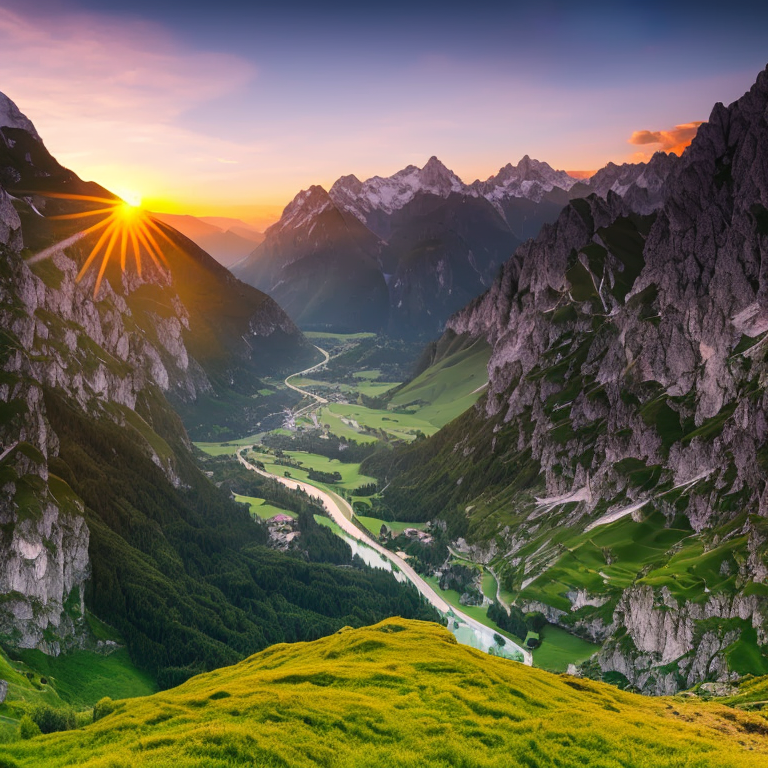

In [13]:
final_image = result["sample"][0]
final_image.save("result.png")
final_image